<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/modern_approach/one_shot_learning/siamese_network_with_triplet_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#One-Shot Learning: Syjamska sieć neuronowa ze stratą trypletu
##Import bibliotek

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

target_shape = (200, 200)

##Załadowanie danych

In [2]:
cache_dir = Path(Path.home()) / '.keras'
anchor_images_path = cache_dir / 'left'
positive_images_path = cache_dir / 'right'

In [3]:
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

Downloading...
From: https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
To: /content/left.zip
104MB [00:01, 85.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
To: /content/right.zip
104MB [00:01, 71.1MB/s] 


##Przygotowanie danych

In [4]:
def preprocess_image(filename):
  img_string = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img_string, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, target_shape)
  return img

def preprocess_triplets(anchor, positive, negative):
  return (
      preprocess_image(anchor),
      preprocess_image(positive),
      preprocess_image(negative)
  )

In [5]:
# Musimy się upewnić czy obrazy anchor i positive zostały załadowane
# w odpowiedniej kolejności, tak abyśmy mogli je porównać.
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

img_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# Aby wygenerować listę obrazów negative przetasujmy listę dostępnych obrazów
# i skonkatenujmy je razem.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Podział danych na treningowe i walidacyjne
train_dataset = dataset.take(round(img_count * 0.8))
val_dataset = dataset.skip(round(img_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

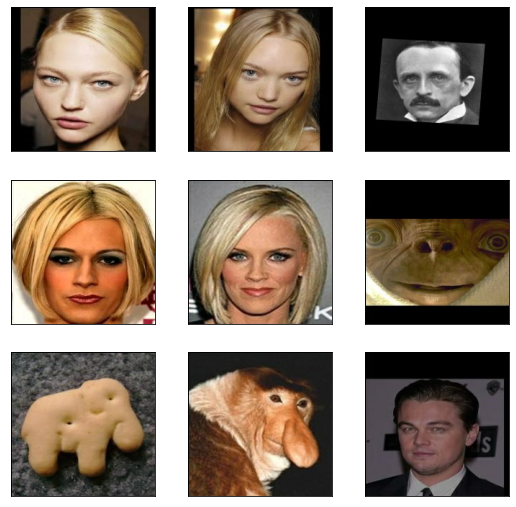

In [7]:
def visualize(anchor, positive, negative):

  def show(ax, img):
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  fig = plt.figure(figsize=(9, 9))

  axs = fig.subplots(3, 3)
  for i in range(3):
    show(axs[i, 0], anchor[i])
    show(axs[i, 1], positive[i])
    show(axs[i, 2], negative[i])

visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

#Model generatora embeddingu

In [8]:
base_cnn = resnet.ResNet50(
    weights='imagenet', input_shape=target_shape +(3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation='relu')(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation='relu')(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name='Embedding')

trainable = False
for layer in base_cnn.layers:
  if layer.name == 'conv5_block1_out':
    trainable = True
  layer.trainable = trainable

94773248/94765736 [==============================] - 1s 0us/step


##Model sieci syjamskiej

In [9]:
class DistanceLayer(layers.Layer):
  
  # Wartstwa odpowiedzialna za oblicznie dystansu między anchor embedding
  # i positive embedding oraz anchor embedding i negative embedding.

  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, anchor, positive, negative):
    ap_dist = tf.reduce_sum(tf.square(anchor - positive), -1)
    an_dist = tf.reduce_sum(tf.square(anchor - negative), -1)
    return (ap_dist, an_dist)


anchor_input = layers.Input(name='anchor', shape=target_shape + (3,))
positive_input = layers.Input(name='positive', shape=target_shape + (3,))
negative_input = layers.Input(name='negative', shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input))
)

siamese_net = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

##Złączenie wszystkiego razem

In [12]:
class SiameseModel(Model):

  def __init__(self, siamese_net, margin=0.5):
    super(SiameseModel, self).__init__()
    self.siamese_net = siamese_net
    self.margin = margin
    self.loss_tracker = metrics.Mean(name='loss')

  def call(self, inputs):
    return self.siamese_net(inputs)

  def train_step(self, data):
    with tf.GradientTape() as tape:
      loss = self._compute_loss(data)

    gradients = tape.gradient(loss, self.siamese_net.trainable_weights)

    self.optimizer.apply_gradients(
        zip(gradients, self.siamese_net.trainable_weights)
    )

    self.loss_tracker.update_state(loss)
    return {'loss': self.loss_tracker.result()}

  def test_step(self, data):
    loss = self._compute_loss(data)

    self.loss_tracker.update_state(loss)
    return {'loss': self.loss_tracker.result()}

  def _compute_loss(self, data):
    ap_dist, an_dist = self.siamese_net(data)

    loss = ap_dist - an_dist
    loss = tf.maximum(loss + self.margin, 0.0)
    return loss

  @property
  def metrics(self):
    return [self.loss_tracker]

##Trening

In [13]:
siamese_model = SiameseModel(siamese_net)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
151/151 [==============================] - 83s 505ms/step - loss: 0.4071 - val_loss: 0.3616
Epoch 2/10
151/151 [==============================] - 74s 490ms/step - loss: 0.3831 - val_loss: 0.3469
Epoch 3/10
151/151 [==============================] - 74s 492ms/step - loss: 0.3644 - val_loss: 0.3365
Epoch 4/10
151/151 [==============================] - 74s 491ms/step - loss: 0.3421 - val_loss: 0.3345
Epoch 5/10
151/151 [==============================] - 74s 491ms/step - loss: 0.3412 - val_loss: 0.3306
Epoch 6/10
151/151 [==============================] - 74s 492ms/step - loss: 0.3235 - val_loss: 0.3263
Epoch 7/10
151/151 [==============================] - 74s 491ms/step - loss: 0.3163 - val_loss: 0.3205
Epoch 8/10
151/151 [==============================] - 74s 491ms/step - loss: 0.2985 - val_loss: 0.2744
Epoch 9/10
151/151 [==============================] - 74s 491ms/step - loss: 0.2996 - val_loss: 0.3108
Epoch 10/10
151/151 [==============================] - 74s 491ms/step - l

##Sprawdzenie czego sieć się nauczyła

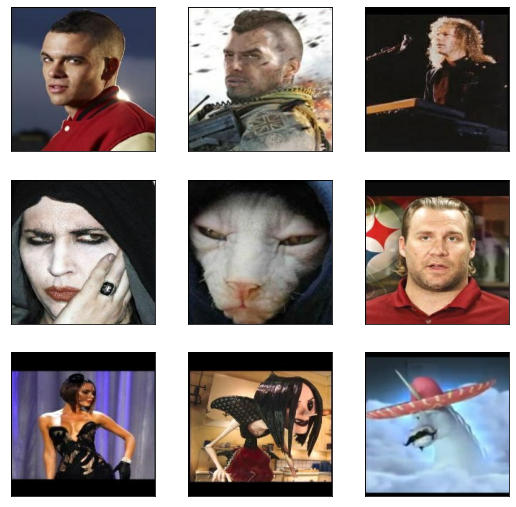

In [15]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative))
)

In [16]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print('Positive similarity:', positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print('Positive similarity:', negative_similarity.numpy())

Positive similarity: 0.99454284
Positive similarity: 0.9921832
